In [1]:
# ------------------------------------------
# Script: 5 (Model_properties.ipynb)
# ------------------------------------------
# Author: Pratyay Sengupta
# ------------------------------------------

In [35]:
# Import required libraries
import cobra
import glob
import itertools
import matplotlib.pyplot as plt
import networkx as nx
import os
import pandas as pd
import random
import seaborn as sns
import numpy as np
from itertools import combinations
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from scipy.spatial.distance import pdist, squareform
from scipy.stats import mannwhitneyu
from scipy.stats import ks_2samp
from skbio.stats.distance import DistanceMatrix
from skbio.stats.distance import permanova

# Set data directories
input_dir = '/mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Output_data/network_files/'
model_dir = '/mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Modeling/Models/'
output_dir = '/mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Modeling/'
distance_dir = '/mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Output_data/distances/'
figures_dir = '/mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Figures/'
sample_dir = '/mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Output_data/phyloseq_source/'

In [40]:
# --------------------------------------------------------
# Load metabolic models
# --------------------------------------------------------

os.chdir(model_dir)
model_info = pd.DataFrame(columns=["Model", "Predicted growth rate", "Number of Genes", "Number of Metabolites", "Number of Reactions"])

for model_file in os.listdir(model_dir):
    if model_file.endswith(".xml"): 
        model = cobra.io.read_sbml_model(model_file)
        solution = model.optimize()
        model_info.loc[len(model_info)] = {
            "Model": model_file,
            "Predicted growth rate": solution.objective_value,
            "Number of Genes": len(model.genes),
            "Number of Metabolites": len(model.metabolites),
            "Number of Reactions": len(model.reactions)
        }

model_info.set_index('Model', inplace=True)
model_info.to_csv(output_dir + 'model_info.csv', sep=",")

# Display the model info
model_info.head()

Adding exchange reaction EX_12ppd__R_e with default bounds for boundary metabolite: 12ppd__R_e.
Adding exchange reaction EX_14glucan_e with default bounds for boundary metabolite: 14glucan_e.
Adding exchange reaction EX_26dap__M_e with default bounds for boundary metabolite: 26dap__M_e.
Adding exchange reaction EX_2mpa_e with default bounds for boundary metabolite: 2mpa_e.
Adding exchange reaction EX_3amp_e with default bounds for boundary metabolite: 3amp_e.
Adding exchange reaction EX_3cmp_e with default bounds for boundary metabolite: 3cmp_e.
Adding exchange reaction EX_3mba_e with default bounds for boundary metabolite: 3mba_e.
Adding exchange reaction EX_3ump_e with default bounds for boundary metabolite: 3ump_e.
Adding exchange reaction EX_4abut_e with default bounds for boundary metabolite: 4abut_e.
Adding exchange reaction EX_4hpro_LT_e with default bounds for boundary metabolite: 4hpro_LT_e.
Adding exchange reaction EX_LalaDgluMdap_e with default bounds for boundary metabolite

Predicted growth rate  Number of Genes  \
Model                                                                    
Abiotrophia_defectiva.xml                   45.124805              421   
Achromobacter_xylosoxidans.xml              62.062721             1237   
Acinetobacter_baumannii.xml                 32.601758              968   
Acinetobacter_johnsonii.xml                 37.414989              760   
Acinetobacter_junii.xml                     28.275133              732   

                                Number of Metabolites  Number of Reactions  
Model                                                                       
Abiotrophia_defectiva.xml                         820                 1154  
Achromobacter_xylosoxidans.xml                   1638                 2446  
Acinetobacter_baumannii.xml                      1433                 1993  
Acinetobacter_johnsonii.xml                      1141                 1600  
Acinetobacter_junii.xml                          1098                 1560

In [36]:
# --------------------------------------------------------
# Load interaction networks and abundance data
# --------------------------------------------------------

environments = ["Hospital", "Metro", "Office"]
nodes_info, edges_info, sample_info = {}, {}, {}

for env in environments:
    edges = pd.read_csv(input_dir + env + '_edges.tsv', sep=",")
    edges_info[env] = edges
    nodes_info[env] = list(set(edges['v1']).union(set(edges['v2'])))

    sample_df = pd.read_csv(sample_dir + env + '_filtered_data.csv', sep=",")
    sample_df.set_index('Species', inplace=True)
    sample_info[env] = sample_df

In [37]:
# --------------------------------------------------------
# Collect unique interactions across environments
# --------------------------------------------------------

unique_edges = set()
for df in edges_info.values():
    unique_edges.update(zip(df['v1'], df['v2']))
unique_edges_list = list(unique_edges)

# --------------------------------------------------------
# Build networkx graphs for each environment
# --------------------------------------------------------

network_info = {}

for env in environments:
    G = nx.Graph()
    for _, row in edges_info[env].iterrows():
        G.add_edge(row['v1'], row['v2'], weight=row['Weight'])
    network_info[env] = G

In [38]:
# --------------------------------------------------------
# Network-level statistics
# --------------------------------------------------------

network_data = pd.DataFrame(columns=["Network", "Number of Nodes", "Number of Edges"])

for env, G in network_info.items():
    network_data.loc[len(network_data)] = [env, len(G.nodes), len(G.edges)]

network_data.set_index("Network", inplace=True)

In [6]:
# --------------------------------------------------------
# Generate random connected communities
# --------------------------------------------------------

def generate_community(graph, env="Hospital", num_nodes=5, num_subgraphs=10, sample_info=None):
    community_df = {"community id": [], "organism id": []}
    seen_communities = set()
    communities_generated = 0
    attempts = 0
    max_attempts = 20000 * num_subgraphs

    while communities_generated < num_subgraphs and attempts < max_attempts:
        attempts += 1
        nodes = random.sample(list(graph.nodes()), num_nodes)
        node_tuple = tuple(sorted(nodes))

        if node_tuple in seen_communities:
            continue

        subgraph = graph.subgraph(nodes)

        if nx.is_connected(subgraph):
            orgs = list(subgraph.nodes())
            sample_subset = sample_info[env].loc[sample_info[env].index.isin(orgs)]
            if (sample_subset != 0).all().sum() > 0:
                seen_communities.add(node_tuple)
                com_id = f"{env}_{num_nodes}_{num_subgraphs}_{communities_generated + 1}"
                for org in orgs:
                    community_df["community id"].append(com_id)
                    community_df["organism id"].append(org)
                communities_generated += 1

    if communities_generated < num_subgraphs:
        print(f"Warning: Only {communities_generated} communities generated after {attempts} attempts.")

    return pd.DataFrame(community_df)

In [7]:
# --------------------------------------------------------
# Generate community datasets
# --------------------------------------------------------

random.seed(42)
com_size = [2, 3, 4, 5, 6, 7, 8, 9]
num_com = [10]

community_info = pd.DataFrame({"community id": [], "organism id": []})

for env in environments:
    for size in com_size:
        for num in num_com:
            df = generate_community(network_info[env], env=env, num_nodes=size, num_subgraphs=num, sample_info=sample_info)
            community_info = pd.concat([community_info, df], ignore_index=True)
            print(f"Communities generated: {env} for size={size} ... count={len(df)}")

# Model name normalization
community_info['organism id'] = community_info['organism id'].str.replace(' ', '_')
community_info['organism id'] = community_info['organism id'].replace({
    'Kocuria_sp._UCD-OTCP': 'Kocuria_sp.',
    'Roseomonas_sp._B5': 'Roseomonas_sp.',
    'Dermacoccus_sp._Ellin185': 'Dermacoccus_sp.'
})

community_info.to_csv(output_dir + '2_community_info_[2-9].csv', sep="\t", index=False, header=False)


Communities generated: Hospital for size=2 ... count=20
Communities generated: Hospital for size=3 ... count=30
Communities generated: Hospital for size=4 ... count=40
Communities generated: Hospital for size=5 ... count=50
Communities generated: Hospital for size=6 ... count=60
Communities generated: Hospital for size=7 ... count=70
Communities generated: Hospital for size=8 ... count=80
Communities generated: Hospital for size=9 ... count=90
Communities generated: Metro for size=2 ... count=20
Communities generated: Metro for size=3 ... count=30
Communities generated: Metro for size=4 ... count=40
Communities generated: Metro for size=5 ... count=50
Communities generated: Metro for size=6 ... count=60
Communities generated: Metro for size=7 ... count=70
Communities generated: Metro for size=8 ... count=80
Communities generated: Metro for size=9 ... count=90
Communities generated: Office for size=2 ... count=20
Communities generated: Office for size=3 ... count=30
Communities generate

In [8]:
# -----------------------------
# Check for model-community mismatches
# -----------------------------
model_files = [os.path.splitext(os.path.basename(f))[0] 
               for f in glob.glob(os.path.join(model_dir, '*.xml'))]

mismatch = sorted(set(community_info['organism id']) - set(model_files))
print(f"Mismatched Organism IDs (not found in model files): {len(mismatch)}\n", mismatch)

Mismatched Organism IDs (not found in model files): 0
 []


In [54]:
# -----------------------------
# Write Bash Script for global SMETANA Execution
# -----------------------------
smetana_script_path = os.path.join(output_dir, '3_run_smetana_[2-9]_complete.sh')
smetana_output = os.path.join(output_dir, 'Smetana_output', '1_community_info_[2-9]_complete.csv')
inorganic_path = os.path.join(output_dir, 'inorganic.txt')

with open(smetana_script_path, 'w') as f:
    f.write("#!/bin/bash\n")
    f.write(f"smetana {model_dir}/*.xml \\\n")
    f.write(f"    -c {output_dir}/2_community_info_[2-9].csv \\\n")
    f.write(f"    -o {smetana_output} \\\n")
    f.write(f"    --exclude {inorganic_path} \\\n")
    f.write("    --solver cplex --flavor bigg --molweight\n")

# Run the bash script (ensure it's executable)
os.system(f"chmod +x {smetana_script_path}")
os.system(f"bash {smetana_script_path}")

/home/pratyay/anaconda3/envs/modeling/lib/python3.10/site-packages/smetana/smetana.py:351: UserWarning: MRO: Failed to find a valid solution for: Staphylococcus_aureus
  warn('MRO: Failed to find a valid solution for: ' + org_id)


0

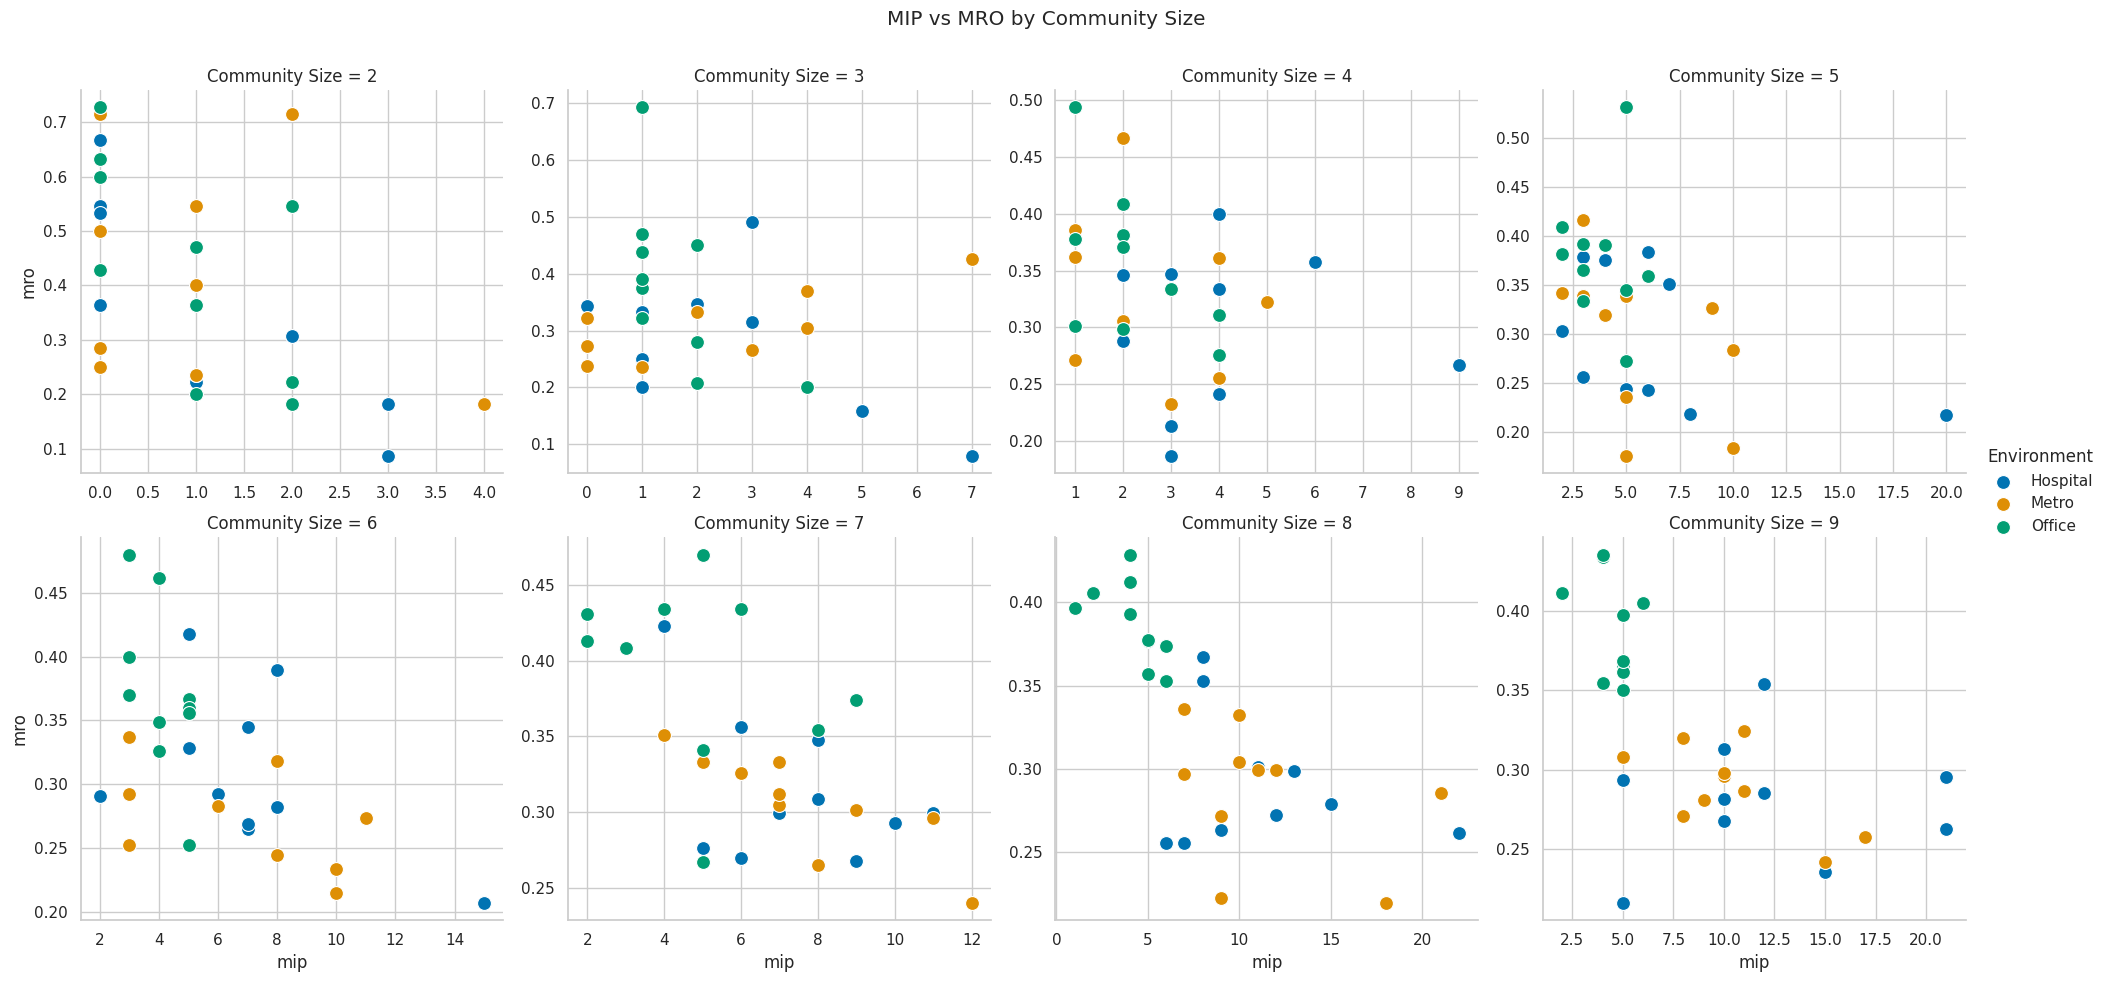

In [39]:
# -----------------------------
# Read and preprocess SMETANA results
# -----------------------------
result_file = os.path.join(output_dir, 'Smetana_output', '1_community_info_[2-9]_complete.csv_global.tsv')
smetana_results = pd.read_csv(result_file, sep="\t").dropna()

# Extract metadata from community IDs
smetana_results[['Environment', 'Community Size', 'Iterations', 'Community Number']] = (
    smetana_results['community'].str.split('_', expand=True)
)

# Convert community size to integer
smetana_results['Community Size'] = smetana_results['Community Size'].astype(int)

# -----------------------------
# Scatterplot Visualization by Community Size
# -----------------------------
sns.set(style="whitegrid")
colorblind_palette = sns.color_palette("colorblind")

envs = smetana_results['Environment'].unique()
custom_palette = {
    env: (0.8, 0.8, 0.8) if env == "Random" else colorblind_palette[i % len(colorblind_palette)]
    for i, env in enumerate(envs)
}

g = sns.FacetGrid(smetana_results, col="Community Size", hue="Environment",
                  palette=custom_palette, col_wrap=4, height=5,
                  sharex=False, sharey=False, legend_out=True)

g.map(sns.scatterplot, 'mip', 'mro', s=100)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("MIP vs MRO by Community Size")
g.add_legend(title="Environment")

# Save the figure
g.savefig(figures_dir + 'Supplementary_Figure_4.svg', dpi=600)

plt.show()


<Figure size 1000x600 with 0 Axes>

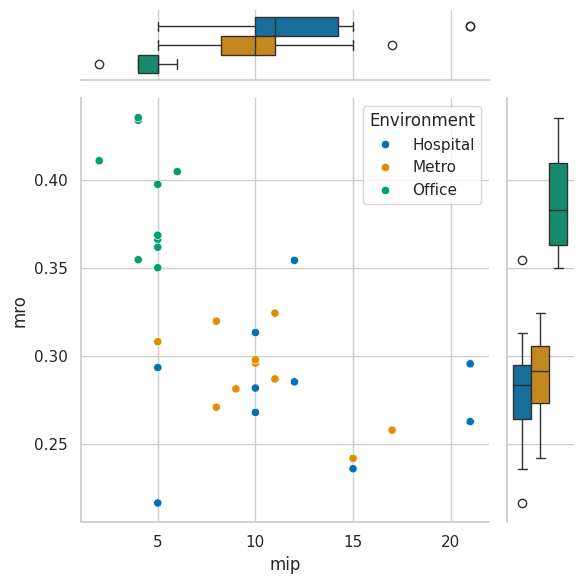

In [30]:
# -----------------------------
# Joint Plot for Community Size 9
# -----------------------------
size9_data = smetana_results[smetana_results["Community Size"] == 9]

plt.figure(figsize=(10, 6))
g1 = sns.JointGrid(data=size9_data, x='mip', y='mro', hue='Environment', palette=custom_palette)
g1.plot(sns.scatterplot, sns.boxplot)

plt.tight_layout()
plt.savefig(figures_dir + 'Figure_5A.svg', dpi=600)
plt.show()


In [31]:
def compute_permanova_with_r2(df, group_col, feature_cols, distance_metric='braycurtis', permutations=999):
    """
    Computes PERMANOVA and R² value based on provided features and grouping.

    Parameters:
    - df: pandas DataFrame containing your data.
    - group_col: column name for group labels (e.g., 'Environment').
    - feature_cols: list of column names used for distance calculation.
    - distance_metric: distance metric for pdist (default: 'braycurtis').
    - permutations: number of permutations for PERMANOVA (default: 999).

    Returns:
    - result: PERMANOVA test result (skbio object).
    - r2: proportion of variation explained by the group (float).
    """
    # Ensure feature columns exist
    if not all(col in df.columns for col in feature_cols):
        raise ValueError("Some feature columns not found in the DataFrame.")

    # Extract features and group labels
    X = df[feature_cols].values
    grouping = df[group_col].values
    ids = df.index.astype(str)

    # Compute distance matrix
    dist_array = pdist(X, metric=distance_metric)
    dist_matrix = squareform(dist_array)
    dm = DistanceMatrix(dist_matrix, ids=ids)

    # Run PERMANOVA
    result = permanova(dm, grouping=grouping, permutations=permutations)

    # Calculate R² manually (based on group centroids)
    grand_centroid = X.mean(axis=0)
    ss_total = np.sum(np.square(X - grand_centroid))

    ss_between = 0
    for group in np.unique(grouping):
        group_X = X[grouping == group]
        group_centroid = group_X.mean(axis=0)
        ss_between += len(group_X) * np.sum(np.square(group_centroid - grand_centroid))

    r2 = ss_between / ss_total if ss_total > 0 else np.nan

    return result, r2


In [32]:
# -----------------------------
# PERMANOVA for Community Size 9
# -----------------------------

result, r2 = compute_permanova_with_r2(
    df=size9_data,
    group_col='Environment',
    feature_cols=['mip', 'mro'],
    distance_metric='braycurtis',
    permutations=999
)

print(result)
print(f"R² value: {r2:.4f}")

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      30
number of groups                  3
test statistic            14.498529
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object
R² value: 0.4432


In [33]:
# -----------------------------
# Load Distance Matrices
# -----------------------------

function_dist = pd.read_csv(distance_dir + '1_functional.tsv', sep='\t', index_col=0)
mash_dist     = pd.read_csv(distance_dir + '2_mash.tsv', sep='\t', index_col=0)
phylo_dist    = pd.read_csv(distance_dir + '3_phylogenetic.tsv', sep='\t', index_col=0)
met_dist      = pd.read_csv(distance_dir + '4_metabolic.tsv', sep='\t', index_col=0)

# Display the distance matrices
function_dist.iloc[:5, :5]

GCF_000019725.1  GCF_000019945.1  GCF_000023145.1  \
GCF_000019725.1           0.0000           0.2078           0.6516   
GCF_000019945.1           0.2078           0.0000           0.6450   
GCF_000023145.1           0.6516           0.6450           0.0000   
GCF_000023925.1           0.6056           0.6067           0.4675   
GCF_000024945.1           0.6612           0.6615           0.5666   

                 GCF_000023925.1  GCF_000024945.1  
GCF_000019725.1           0.6056           0.6612  
GCF_000019945.1           0.6067           0.6615  
GCF_000023145.1           0.4675           0.5666  
GCF_000023925.1           0.0000           0.6163  
GCF_000024945.1           0.6163           0.0000

In [40]:
# -----------------------------
# Load Community Data and Metadata
# -----------------------------

# Load community data
community_data = pd.read_csv(output_dir + '2_community_info_[2-9].csv', sep='\t', header=None)
community_data.columns = ['Community', 'Members']
community_data = community_data[community_data['Community'].str.contains('_9_10')]
community_dict = community_data.groupby('Community')['Members'].apply(list).to_dict()

# Load metadata
metadata_path = '/mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Output_data/'
metadata = pd.read_csv(metadata_path + '3_accession_details.csv', sep=',', index_col=0)
metadata.index = metadata.index.str.replace(' ', '_')
metadata.index = metadata.index.str.replace('Kocuria_sp._UCD-OTCP', 'Kocuria_sp.')
metadata.index = metadata.index.str.replace('Roseomonas_sp._B5', 'Roseomonas_sp.')
metadata.index = metadata.index.str.replace('Dermacoccus_sp._Ellin185', 'Dermacoccus_sp.')

In [41]:
# -----------------------------
# Calculating Mean Distances
# -----------------------------

def mean_dist(community_dict, metadata, dist):
    mean_distances = {}
    for community, members in community_dict.items():
        accessions = metadata.loc[members, 'assembly_accession'].tolist()
        dist_sub = dist.loc[accessions, accessions]
        values = dist_sub.where(np.triu(np.ones(dist_sub.shape), k=1).astype(bool)).stack().values
        mean_distances[community] = np.mean(values)
    return mean_distances

def calculate_mean_all_dist(community_dict, metadata, function_dist, mash_dist, phylo_dist, met_dist):
    return pd.DataFrame({
        'Functional': mean_dist(community_dict, metadata, function_dist),
        'Mash': mean_dist(community_dict, metadata, mash_dist),
        'Phylogenetic': mean_dist(community_dict, metadata, phylo_dist),
        'Metabolic': mean_dist(community_dict, metadata, met_dist)
    })

# --- Compute Mean Distances ---
mean_df = calculate_mean_all_dist(community_dict, metadata, function_dist, mash_dist, phylo_dist, met_dist)
mean_df['Environment'] = mean_df.index.str.split('_').str[0]
mean_df['Category'] = mean_df['Environment']


In [46]:
# Select only the numerical distance columns
distance_df = mean_df[['Functional', 'Mash', 'Phylogenetic', 'Metabolic']]

# Compute the correlation matrix
correlation_matrix = distance_df.corr(method='pearson')

correlation_matrix

Functional      Mash  Phylogenetic  Metabolic
Functional      1.000000  0.509378      0.837481   0.931465
Mash            0.509378  1.000000      0.656089   0.494995
Phylogenetic    0.837481  0.656089      1.000000   0.739264
Metabolic       0.931465  0.494995      0.739264   1.000000

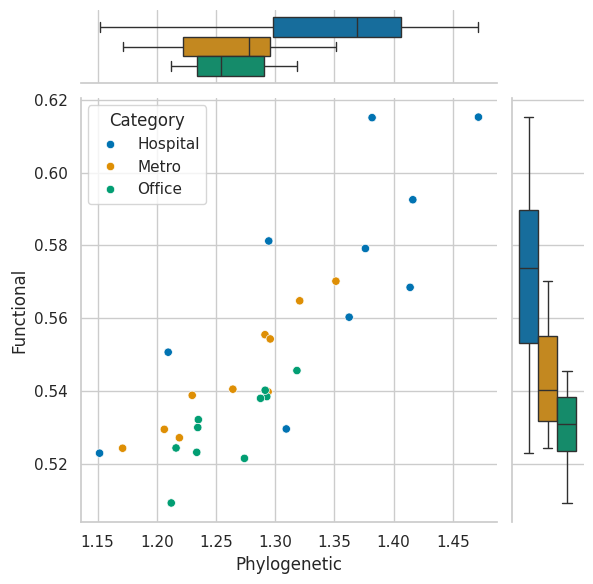

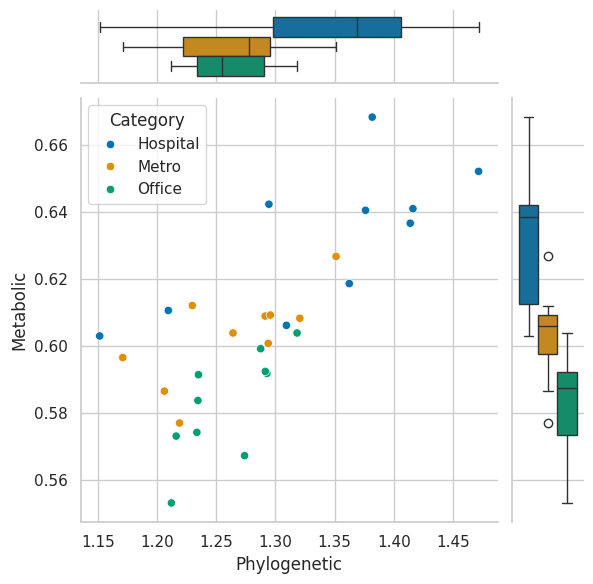

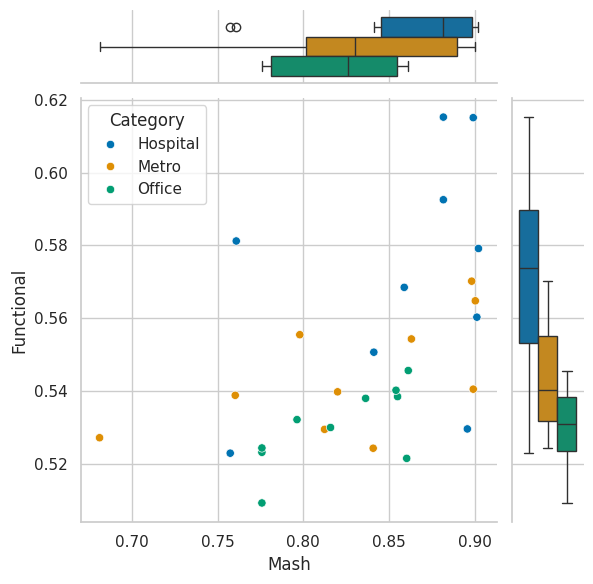

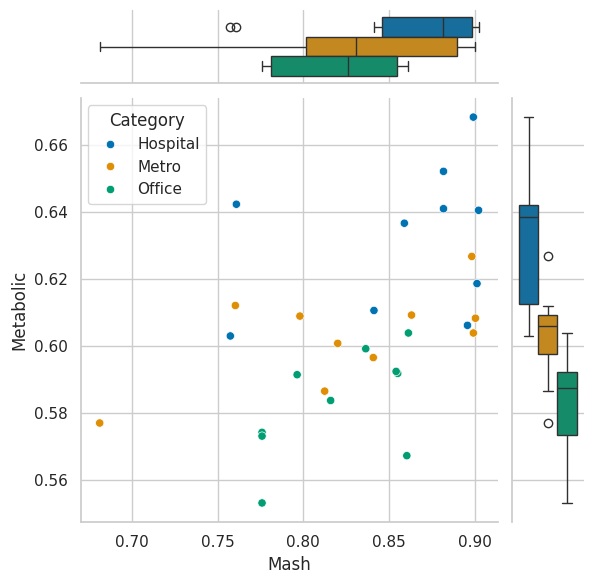

In [42]:
# -----------------------------
# Plotting Functions
# -----------------------------

def plot_jointgrid(x, y, data=mean_df, hue='Category', palette='colorblind', save_dir='plots'):
    # Create output directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Create the plot
    g = sns.JointGrid(data=data, x=x, y=y, hue=hue, palette=palette)
    g.plot(sns.scatterplot, sns.boxplot)
    g.ax_joint.set_xlabel(x)
    g.ax_joint.set_ylabel(y)
    
    # Save the figure
    filename = f"{x}_vs_{y}.svg".replace(' ', '_')
    full_path = os.path.join(figures_dir, filename)
    g.figure.savefig(full_path, dpi=600, bbox_inches='tight')
    
    # Show the plot
    plt.show()

# Plot Pairwise Comparisons 
plot_jointgrid('Phylogenetic', 'Functional')
plot_jointgrid('Phylogenetic', 'Metabolic')
plot_jointgrid('Mash', 'Functional')
plot_jointgrid('Mash', 'Metabolic')

In [43]:
# -----------------------------
# PERMANOVA Calculations
# -----------------------------

# Functional vs Phylogenetic
result_fp, r2_fp = compute_permanova_with_r2(
    df=mean_df,
    group_col='Environment',
    feature_cols=['Phylogenetic', 'Functional'],
    distance_metric='braycurtis',
    permutations=999
)

print("Functional vs Phylogenetic:")
print(result_fp)
print(f"R² value: {r2_fp:.4f}\n")

# Phylogenetic vs Metabolic
result_pm, r2_pm = compute_permanova_with_r2(
    df=mean_df,
    group_col='Environment',
    feature_cols=['Phylogenetic', 'Metabolic'],
    distance_metric='braycurtis',
    permutations=999
)

print("Phylogenetic vs Metabolic:")
print(result_pm)
print(f"R² value: {r2_pm:.4f}\n")

# Mash vs Functional
result_mf, r2_mf = compute_permanova_with_r2(
    df=mean_df,
    group_col='Environment',
    feature_cols=['Mash', 'Functional'],
    distance_metric='braycurtis',
    permutations=999
)
print("Mash vs Functional:")
print(result_mf)
print(f"R² value: {r2_mf:.4f}\n")

# Mash vs Metabolic
result_mm, r2_mm = compute_permanova_with_r2(
    df=mean_df,
    group_col='Environment',
    feature_cols=['Mash', 'Metabolic'],
    distance_metric='braycurtis',
    permutations=999
)

print("Mash vs Metabolic:")
print(result_mm)
print(f"R² value: {r2_mm:.4f}\n")



Functional vs Phylogenetic:
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      30
number of groups                  3
test statistic             5.123508
p-value                       0.015
number of permutations          999
Name: PERMANOVA results, dtype: object
R² value: 0.2542

Phylogenetic vs Metabolic:
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      30
number of groups                  3
test statistic              6.70664
p-value                       0.008
number of permutations          999
Name: PERMANOVA results, dtype: object
R² value: 0.2730

Mash vs Functional:
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      30
number of groups                  3
test statistic             3.376216
p-value                       0.035
number of permutations          999
Name: PERMANOVA results, dtype: object
R² value: 0.1473

In [17]:
# -----------------------------
# Setup Paths for Detailed SMETANA
# -----------------------------

output_base = output_dir + "Community_9_detailed_segregated/"
comm_file_path = os.path.join(output_base, "comm_file/")
bash_file_path = os.path.join(output_base, "bash_file/")
result_path = os.path.join(output_base, "Smetana_output/")
os.makedirs(comm_file_path, exist_ok=True)
os.makedirs(bash_file_path, exist_ok=True)
os.makedirs(result_path, exist_ok=True)

# Filter communities for size 9
comm_9 = community_info[community_info['community id'].str.split('_').str[1].str.endswith('9')]
comm_9.to_csv(os.path.join(output_dir, '4_community_info_9.csv'), sep="\t", index=False, header=False)

In [155]:
# -----------------------------
# Generate and Run Detailed SMETANA
# -----------------------------

def run_smetana_for_communities(comm_df):
    for community, group in comm_df.groupby("community id"):
        csv_file = os.path.join(comm_file_path, f"community_info_{community}.csv")
        bash_file = os.path.join(bash_file_path, f"run_smetana_{community}_detailed.sh")

        # Save community members
        group.to_csv(csv_file, sep="\t", index=False, header=False)

        # Write bash script
        with open(bash_file, "w") as f:
            f.write("#!/bin/bash\n")
            f.write("smetana /mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Modeling/Models/*.xml \\\n")
            f.write(f"    -c {csv_file} \\\n")
            f.write(f"    -o {os.path.join(result_path, f'result_{community}.tsv')} \\\n")
            f.write(f"    --exclude {inorganic_path} \\\n")
            f.write("    --detailed --solver cplex --flavor bigg --molweight\n")

        os.chmod(bash_file, 0o755)
        os.system(f"bash {bash_file}")
        print(f"Completed SMETANA run for community: {community}")

run_smetana_for_communities(comm_9)


Completed SMETANA run for community: Hospital_9_10_1
Completed SMETANA run for community: Hospital_9_10_10
Completed SMETANA run for community: Hospital_9_10_2
Completed SMETANA run for community: Hospital_9_10_3
Completed SMETANA run for community: Hospital_9_10_4
Completed SMETANA run for community: Hospital_9_10_5
Completed SMETANA run for community: Hospital_9_10_6
Completed SMETANA run for community: Hospital_9_10_7
Completed SMETANA run for community: Hospital_9_10_8
Completed SMETANA run for community: Hospital_9_10_9
Completed SMETANA run for community: Metro_9_10_1
Completed SMETANA run for community: Metro_9_10_10
Completed SMETANA run for community: Metro_9_10_2
Completed SMETANA run for community: Metro_9_10_3
Completed SMETANA run for community: Metro_9_10_4
Completed SMETANA run for community: Metro_9_10_5
Completed SMETANA run for community: Metro_9_10_6
Completed SMETANA run for community: Metro_9_10_7
Completed SMETANA run for community: Metro_9_10_8
Completed SMETANA 

/mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Modeling/Community_9_detailed_segregated/bash_file/run_smetana_Office_9_10_1_detailed.sh: line 6: 1329381 Segmentation fault      (core dumped) smetana /mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Modeling/Models/*.xml -c /mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Modeling/Community_9_detailed_segregated/comm_file/community_info_Office_9_10_1.csv -o /mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Modeling/Community_9_detailed_segregated/Smetana_output/result_Office_9_10_1.tsv --exclude /mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Modeling/inorganic.txt --detailed --solver cplex --flavor bigg --molweight


Completed SMETANA run for community: Office_9_10_1
Completed SMETANA run for community: Office_9_10_10
Completed SMETANA run for community: Office_9_10_2


/mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Modeling/Community_9_detailed_segregated/bash_file/run_smetana_Office_9_10_3_detailed.sh: line 6: 1339705 Segmentation fault      (core dumped) smetana /mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Modeling/Models/*.xml -c /mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Modeling/Community_9_detailed_segregated/comm_file/community_info_Office_9_10_3.csv -o /mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Modeling/Community_9_detailed_segregated/Smetana_output/result_Office_9_10_3.tsv --exclude /mnt/Local_Disk_1/2_Hospital_Microbiome/Data/Modeling/inorganic.txt --detailed --solver cplex --flavor bigg --molweight


Completed SMETANA run for community: Office_9_10_3
Completed SMETANA run for community: Office_9_10_4
Completed SMETANA run for community: Office_9_10_5
Completed SMETANA run for community: Office_9_10_6
Completed SMETANA run for community: Office_9_10_7
Completed SMETANA run for community: Office_9_10_8
Completed SMETANA run for community: Office_9_10_9


In [24]:
# -----------------------------
# Read SMETANA Results
# -----------------------------

def parse_smetana_outputs(path):
    exchange_dict = {}
    for file in os.listdir(path):
        if file.endswith(".tsv"):
            df = pd.read_csv(os.path.join(path, file), sep="\t")
            count_df = df['compound'].value_counts().reset_index()
            count_df.columns = ['compound', 'count']
            exchange_dict[file] = count_df
    return exchange_dict

exchanges = parse_smetana_outputs(result_path)

In [52]:
# -----------------------------
# Aggregate Results by Environment
# -----------------------------

met_name = pd.read_csv(os.path.join(output_dir, 'bigg_models_metabolites.txt'), sep="\t")
hmdb_subclass = pd.read_csv(os.path.join(output_dir, 'HMDB_subclass.tsv'), sep="\t")

# Ensure required columns
mapping_dict = dict(zip(met_name['universal_bigg_id'], met_name['name']))
mapping_class = dict(zip(hmdb_subclass['Compound'], hmdb_subclass['HMDB_Subclass']))

def summarize_by_environment(exchanges, environments, mapping_dict, mapping_class):
    env_data = {env: [] for env in environments}
    for fname, df in exchanges.items():
        for env in environments:
            if env in fname:
                env_data[env].append(df)
                break

    result = {}
    for env, dfs in env_data.items():
        if dfs:
            merged = pd.concat(dfs)
            summarized = merged.groupby('compound', as_index=False)['count'].sum()
            summarized.sort_values(by='count', ascending=False, inplace=True)
            summarized['compound'] = summarized['compound'].str.replace(r'^M_(.*)_e$', r'\1', regex=True)
            summarized['compound_name'] = summarized['compound'].map(mapping_dict)
            summarized['HMDB_Subclass'] = summarized['compound_name'].map(mapping_class)
            subclass_summary = summarized.groupby('HMDB_Subclass')['count'].sum().reset_index()
            result[env] = subclass_summary
    return result

environments = ['Hospital', 'Metro', 'Office']
result = summarize_by_environment(exchanges, environments, mapping_dict, mapping_class)

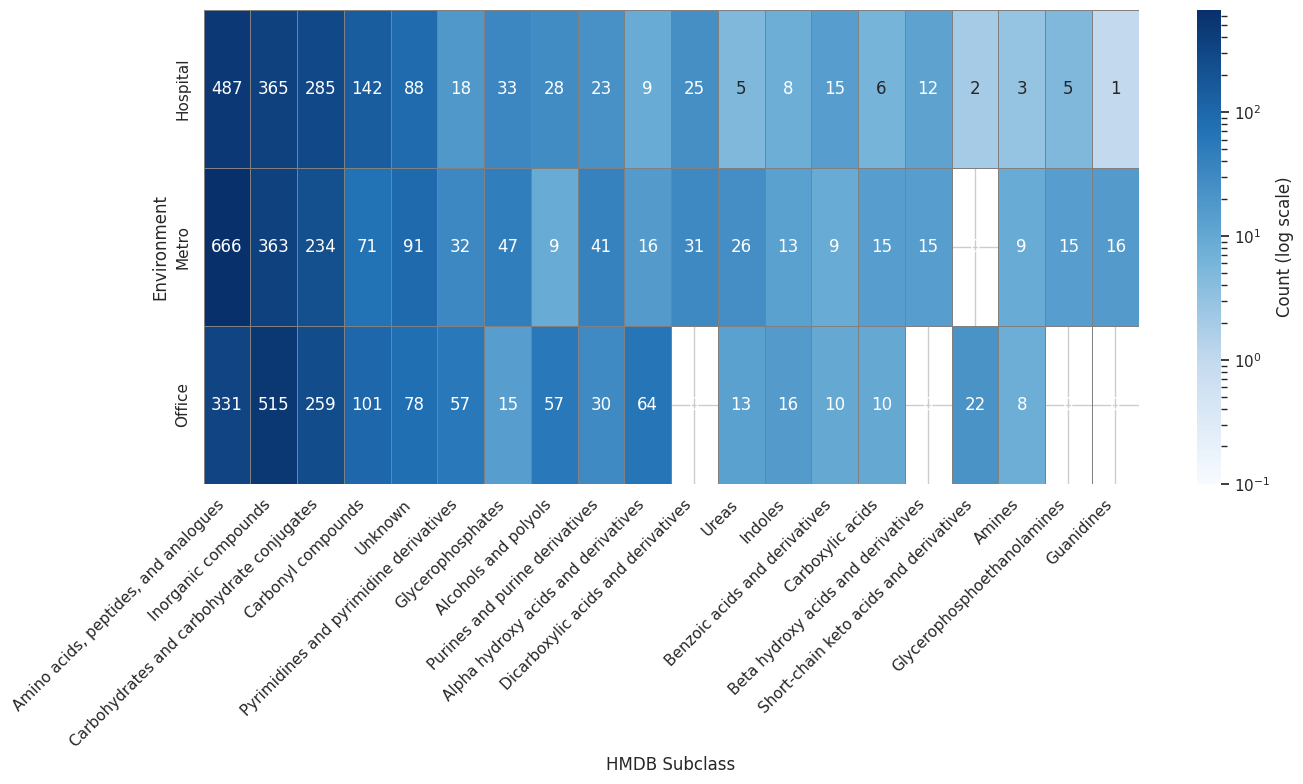

In [53]:
# -----------------------------
# Plotting Results
# -----------------------------

def create_heatmap(data_dict, plot_path, filename="HMDB_subclass_heatmap_top10.png"):
    # Combine environment data into a single dataframe
    full_df = pd.DataFrame({
        env: df.set_index('HMDB_Subclass')['count']
        for env, df in data_dict.items()
    }).fillna(0).T

    # Compute total counts across environments to find top 15 subclasses
    top_subclasses = full_df.sum(axis=0).nlargest(20).index
    top_df = full_df[top_subclasses]

    # Create custom colormap
    cmap = LinearSegmentedColormap.from_list("custom_blue", 
        ["#f7fbff", "#c6dbef", "#6baed6", "#2171b5", "#08306b"], N=256)

    plt.figure(figsize=(14, 8))
    sns.heatmap(
        top_df,
        cmap=cmap,
        norm=LogNorm(vmin=top_df.values.min() + 1e-1, vmax=top_df.values.max()),
        linewidths=0.5,
        linecolor='gray',
        annot=True,
        fmt=".0f",
        cbar_kws={'label': 'Count (log scale)'}
    )

    plt.ylabel('Environment', fontsize=12)
    plt.xlabel('HMDB Subclass', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Save plot
    full_plot_path = os.path.join(plot_path, filename)
    plt.savefig(full_plot_path, dpi=600)
    plt.show()
    plt.close()
    
create_heatmap(result, figures_dir, filename="Figure_5B.svg")